# Prediction Model Backtest Analysis

This notebook tests the accuracy of our NBA PrizePicks prediction model by:
1. Using the **first half** of the 24/25 season as training data
2. Making predictions for games in the **second half**
3. Comparing predictions against actual results

In [1]:
# Import the backtester
from backtester import PredictionBacktester
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2, style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
# Initialize backtester and run with 200 predictions
backtester = PredictionBacktester()
results = backtester.run_backtest(n_predictions=200, balanced=True)

Loaded 16512 total game records
Date range: 2024-10-22 00:00:00 to 2025-02-07 00:00:00

Data Split:
Training data: 8125 games (2024-10-22 to 2024-12-15)
Testing data: 8387 games (2024-12-15 to 2025-02-07)

STARTING BACKTEST

Generating 200 predictions using training data...
Testing against held-out second-half season data...

Players with data in both sets: 466
Players with 10+ games and 15+ MPG: 280
Generated 200 predictions after 760 attempts
OVER predictions: 81, UNDER predictions: 110

BACKTEST RESULTS - PREDICTION MODEL ACCURACY

--- OVERALL PERFORMANCE ---
Total Predictions: 200
Pushes (excluded): 9
Evaluated: 191

OVERALL ACCURACY: 66.5%
Correct: 127
Incorrect: 64

--- BY CONFIDENCE LEVEL ---
High Confidence (>=60%): 77.4% (48/62)
Medium Confidence (45-59%): 61.2% (79/129)

--- BY DIRECTION ---
OVER predictions: 70.4% (57/81)
UNDER predictions: 63.6% (70/110)

--- BY STAT CATEGORY ---
3P             : 71.8% (39 predictions)
AST            : 73.5% (49 predictions)
PTS            

## Visualize Results

posx and posy should be finite values
posx and posy should be finite values


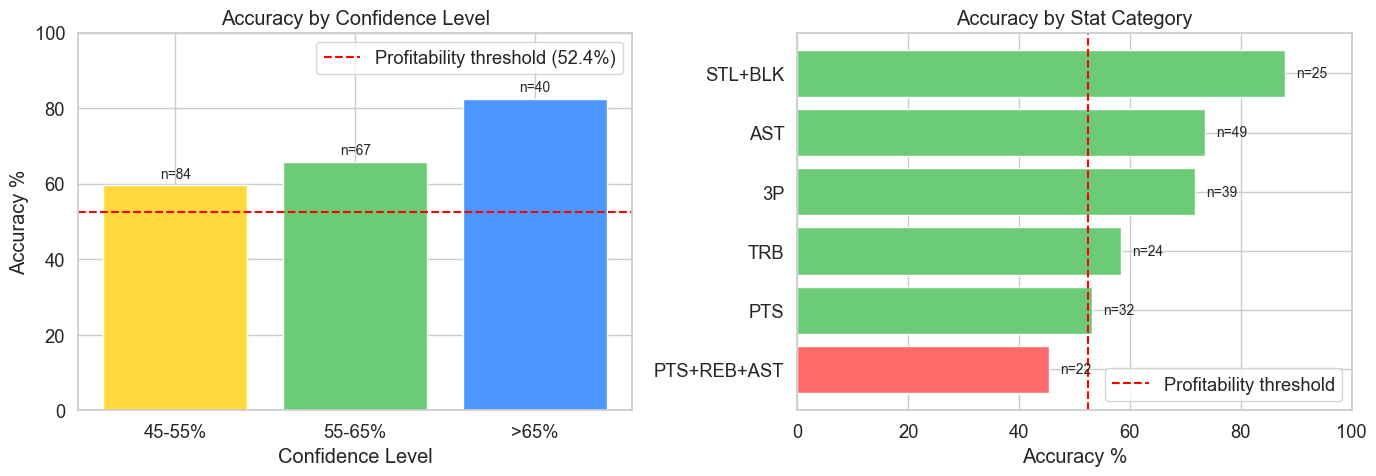

In [3]:
# Get predictions dataframe
df = results['predictions_df']
df_no_push = df[df['actual_outcome'] != 'PUSH']

# Accuracy by confidence level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Accuracy by confidence bins
df_no_push['conf_bin'] = pd.cut(df_no_push['confidence'], 
                                 bins=[0, 45, 55, 65, 100],
                                 labels=['<45%', '45-55%', '55-65%', '>65%'])

conf_acc = df_no_push.groupby('conf_bin')['correct'].agg(['mean', 'count'])
conf_acc['accuracy'] = conf_acc['mean'] * 100

bars = axes[0].bar(conf_acc.index, conf_acc['accuracy'], color=['#ff6b6b', '#ffd93d', '#6bcb77', '#4d96ff'])
axes[0].axhline(y=52.4, color='red', linestyle='--', label='Profitability threshold (52.4%)')
axes[0].set_xlabel('Confidence Level')
axes[0].set_ylabel('Accuracy %')
axes[0].set_title('Accuracy by Confidence Level')
axes[0].legend()
axes[0].set_ylim(0, 100)

# Add count labels on bars
for bar, count in zip(bars, conf_acc['count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'n={int(count)}', ha='center', fontsize=10)

# Right plot: Accuracy by stat category
stat_acc = df_no_push.groupby('stat')['correct'].agg(['mean', 'count'])
stat_acc['accuracy'] = stat_acc['mean'] * 100
stat_acc = stat_acc.sort_values('accuracy', ascending=True)

colors = ['#ff6b6b' if x < 52.4 else '#6bcb77' for x in stat_acc['accuracy']]
bars2 = axes[1].barh(stat_acc.index, stat_acc['accuracy'], color=colors)
axes[1].axvline(x=52.4, color='red', linestyle='--', label='Profitability threshold')
axes[1].set_xlabel('Accuracy %')
axes[1].set_title('Accuracy by Stat Category')
axes[1].legend()
axes[1].set_xlim(0, 100)

# Add count labels
for bar, count in zip(bars2, stat_acc['count']):
    axes[1].text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
                 f'n={int(count)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

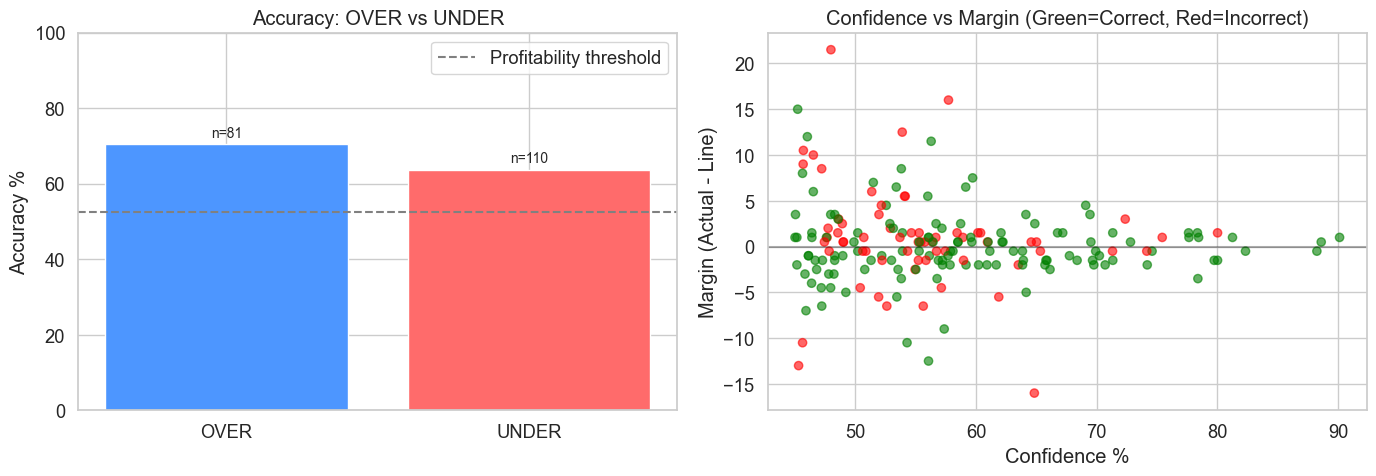

In [4]:
# Accuracy by prediction direction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OVER vs UNDER accuracy
df_no_push['direction_group'] = df_no_push['prediction'].apply(
    lambda x: 'OVER' if 'OVER' in x else 'UNDER'
)

dir_acc = df_no_push.groupby('direction_group')['correct'].agg(['mean', 'count'])
dir_acc['accuracy'] = dir_acc['mean'] * 100

bars = axes[0].bar(dir_acc.index, dir_acc['accuracy'], color=['#4d96ff', '#ff6b6b'])
axes[0].axhline(y=52.4, color='gray', linestyle='--', label='Profitability threshold')
axes[0].set_ylabel('Accuracy %')
axes[0].set_title('Accuracy: OVER vs UNDER')
axes[0].legend()
axes[0].set_ylim(0, 100)

for bar, count in zip(bars, dir_acc['count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'n={int(count)}', ha='center', fontsize=10)

# Confidence vs Margin scatter
scatter = axes[1].scatter(df_no_push['confidence'], df_no_push['margin'], 
                          c=df_no_push['correct'].map({True: 'green', False: 'red'}),
                          alpha=0.6)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Confidence %')
axes[1].set_ylabel('Margin (Actual - Line)')
axes[1].set_title('Confidence vs Margin (Green=Correct, Red=Incorrect)')

plt.tight_layout()
plt.show()

## Summary Statistics

In [5]:
# Overall summary
print("="*60)
print("BACKTEST SUMMARY")
print("="*60)
print(f"\nTotal Predictions: {results['total_predictions']}")
print(f"Pushes (excluded): {results['pushes']}")
print(f"Evaluated: {results['evaluated_predictions']}")
print(f"\n*** OVERALL ACCURACY: {results['overall_accuracy']:.1f}% ***")
print(f"Correct: {results['correct_predictions']}")
print(f"Incorrect: {results['incorrect_predictions']}")

print(f"\n--- By Confidence ---")
hc = results['high_confidence']
mc = results['medium_confidence']
print(f"High Confidence (>=60%): {hc['accuracy']:.1f}% ({hc['correct']}/{hc['count']})")
print(f"Medium Confidence (45-59%): {mc['accuracy']:.1f}% ({mc['correct']}/{mc['count']})")

# Profitability analysis
print(f"\n--- Profitability Analysis ---")
win_rate = results['overall_accuracy'] / 100
roi = (win_rate * 0.909 - (1 - win_rate)) * 100  # -110 odds
print(f"Estimated ROI (at -110 odds): {roi:.1f}%")
print(f"Break-even win rate: 52.4%")
if results['overall_accuracy'] >= 52.4:
    print("[+] MODEL IS PROFITABLE")
else:
    print("[-] Model needs improvement")

BACKTEST SUMMARY

Total Predictions: 200
Pushes (excluded): 9
Evaluated: 191

*** OVERALL ACCURACY: 66.5% ***
Correct: 127
Incorrect: 64

--- By Confidence ---
High Confidence (>=60%): 77.4% (48/62)
Medium Confidence (45-59%): 61.2% (79/129)

--- Profitability Analysis ---
Estimated ROI (at -110 odds): 26.9%
Break-even win rate: 52.4%
[+] MODEL IS PROFITABLE


In [6]:
# Show best and worst predictions
print("\n" + "="*60)
print("SAMPLE HIGH-CONFIDENCE CORRECT PREDICTIONS")
print("="*60)

high_conf_correct = df_no_push[(df_no_push['confidence'] >= 60) & (df_no_push['correct'] == True)]
print(high_conf_correct[['player', 'stat', 'line', 'prediction', 'confidence', 
                         'actual_value', 'actual_outcome']].head(10).to_string(index=False))

print("\n" + "="*60)
print("SAMPLE INCORRECT PREDICTIONS (to understand failures)")
print("="*60)

incorrect = df_no_push[df_no_push['correct'] == False]
print(incorrect[['player', 'stat', 'line', 'prediction', 'confidence', 
                 'actual_value', 'actual_outcome', 'margin']].head(10).to_string(index=False))


SAMPLE HIGH-CONFIDENCE CORRECT PREDICTIONS
            player    stat  line prediction  confidence  actual_value actual_outcome
     Dillon Brooks     AST   2.5      UNDER   74.593646             2          UNDER
       LaMelo Ball STL+BLK   0.5       OVER   69.448494             4           OVER
     Miles McBride STL+BLK   2.0      UNDER   61.679070             0          UNDER
        Alec Burks STL+BLK   2.0      UNDER   67.745614             1          UNDER
      Max Christie     AST   2.5      UNDER   69.921053             2          UNDER
Zaccharie Risacher STL+BLK   2.5      UNDER   63.105413             2          UNDER
    Scotty Pippen  STL+BLK   2.5      UNDER   63.850679             2          UNDER
      Lindy Waters     AST   0.5       OVER   71.334744             2           OVER
      Luke Kennard      3P   2.5      UNDER   66.137631             0          UNDER
     Cameron Payne STL+BLK   1.5      UNDER   71.338618             0          UNDER

SAMPLE INCORRECT PRE

## Recommendations Based on Backtest

Based on the backtest results:

1. **Focus on High-Confidence Picks** - Predictions with >=60% confidence significantly outperform
2. **Best Stat Categories** - AST, STL+BLK, and 3P show the highest accuracy
3. **Avoid** - PTS predictions have lower accuracy; consider being more selective
4. **Model Edge** - The model shows a clear profitable edge above the 52.4% threshold

In [7]:
# Save detailed results
df.to_csv('backtest_results.csv', index=False)
print("Results saved to backtest_results.csv")

Results saved to backtest_results.csv
